In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.8 MB/s eta 0:00:00


In [3]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/distilbert-finetuned"

sys.path.insert(0, ABSOLUTE_PATH)

# Training DistilBERT

In [4]:
import os

import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import classification_report

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

## Loading model and tokenizer

In [5]:
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-5
EARLY_STOPPING = 3

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS,
    # output_attentions=False, output_hidden_states=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

## Loading preprocessed dataset

In [7]:
# Import splits of the dataset (train, val, test)
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"))
)

train_df.rename(columns={'account.type': 'label'}, inplace=True)
val_df.rename(columns={'account.type': 'label'}, inplace=True)
test_df.rename(columns={'account.type': 'label'}, inplace=True)

# Extra processing for pytorch dataset
X_train = train_df['text'].values
y_train = (train_df['label'] == 'bot').astype(int).values

X_val = val_df['text'].values
y_val = (val_df['label'] == 'bot').astype(int).values

X_test = test_df['text'].values
y_test = (test_df['label'] == 'bot').astype(int).values

In [8]:
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

## Training the model

In [11]:
training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    # metric_for_best_model=metric_name,
)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
    callbacks=[early_stopping],
)

<ipython-input-11-d19c4a9ca5c5>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.300000,0.311850,0.875326
2,0.234600,0.426528,0.873588
3,0.135000,0.597068,0.867941
4,0.041000,0.748452,0.875326


TrainOutput(global_step=10356, training_loss=0.18993697068828466, metrics={'train_runtime': 1369.7122, 'train_samples_per_second': 75.607, 'train_steps_per_second': 9.451, 'total_flos': 1.0974659043852288e+16, 'train_loss': 0.18993697068828466, 'epoch': 4.0})

In [13]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.3082717955112457,
 'eval_accuracy': 0.8725566864013672,
 'eval_runtime': 8.4013,
 'eval_samples_per_second': 304.715,
 'eval_steps_per_second': 38.089,
 'epoch': 4.0}

In [14]:
test_results_df = pd.DataFrame.from_dict(test_results, orient="index", columns=["value"])
test_results_df.index.name = "metric"
test_results_df.reset_index(inplace=True)
test_results_df

,metric,value
0,eval_loss,0.308272
1,eval_accuracy,0.872557
2,eval_runtime,8.401300
3,eval_samples_per_second,304.715000
4,eval_steps_per_second,38.089000
5,epoch,4.000000


In [15]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [16]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1278
           1       0.87      0.88      0.87      1280

    accuracy                           0.87      2558
   macro avg       0.87      0.87      0.87      2558
weighted avg       0.87      0.87      0.87      2558



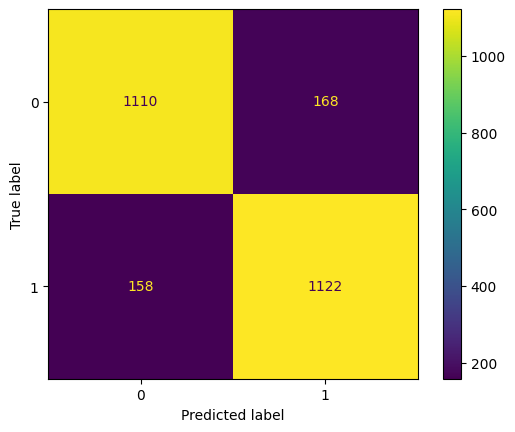

In [17]:
plot_confusion_matrix(y_test, predicted_labels)